In [1]:
import matplotlib.pyplot as plt
from ANN_models import PredictionModel
import os 
import json
import torch
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

/home/md703/.conda/envs/SCS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
result_folder = "PredictionModel_test_muscle_1"

In [3]:
os.makedirs(os.path.join("pic", result_folder), exist_ok=True)
test_result = pd.read_csv(os.path.join("model_test", result_folder, "test.csv"))

In [4]:
def t_test(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1)
    std2 = np.std(group2)
    nobs1 = len(group1)
    nobs2 = len(group2)
    
    modified_std1 = np.sqrt(np.float32(nobs1)/
                    np.float32(nobs1-1)) * std1
    modified_std2 = np.sqrt(np.float32(nobs2)/
                    np.float32(nobs2-1)) * std2
    
    statistic, pvalue = stats.ttest_ind_from_stats( 
               mean1=mean1, std1=modified_std1, nobs1=nobs1,   
               mean2=mean2, std2=modified_std2, nobs2=nobs2)
   
    return statistic, pvalue

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

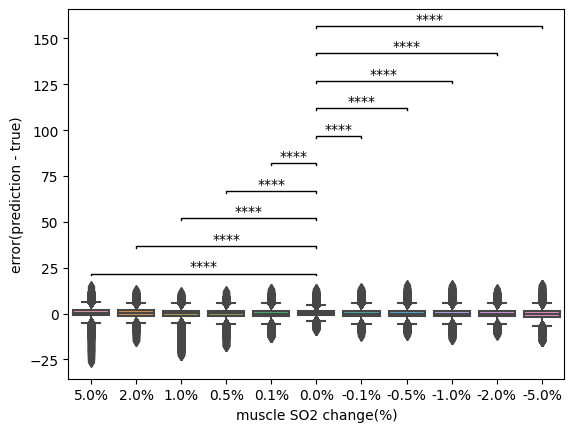

In [5]:
muscle_SO2_dict = {}
for muscle_mua_change in test_result['muscle_mua_change'].unique():
    temp = test_result[test_result['muscle_mua_change']==muscle_mua_change]
    error = temp['error_ijv_SO2'].to_list()
    muscle_SO2_dict[f'{muscle_mua_change}_error_ijv_SO2'] = error
# do t-test one-tail
for muscle_mua_change in test_result['muscle_mua_change'].unique():
    statistic, pvalue = t_test(muscle_SO2_dict['0.0_error_ijv_SO2'],muscle_SO2_dict[f'{muscle_mua_change}_error_ijv_SO2'])
    muscle_SO2_dict[f'{muscle_mua_change}_pvalue'] = pvalue
    
data_y = []
data_x = []
p_val = []
for muscle_mua_change in sorted(test_result['muscle_mua_change'].unique(), reverse=True):
    data_y.append(muscle_SO2_dict[f'{muscle_mua_change}_error_ijv_SO2'])
    data_x.append(f'{muscle_mua_change:.1f}%')
    p_val.append(muscle_SO2_dict[f'{muscle_mua_change}_pvalue'])

ax = sns.boxplot(data=data_y)
count = 5
for i in range(len(data_x)):
    if i==5:
        continue
    else:
        x1,x2 = 5,i
        y,h = max(test_result['error_ijv_SO2'])+count, 1
        #绘制横线位置
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k") 
        #添加P值
        ax.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(p_val[i]), ha='center', va='bottom', color="k")
        count += 15

plt.xticks([i for i in range(len(data_y))],data_x)
plt.xlabel("muscle SO2 change(%)")
plt.ylabel("error(prediction - true)")
plt.savefig(os.path.join("pic", result_folder, f"muscle_change_{muscle_mua_change}_boxplot.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()


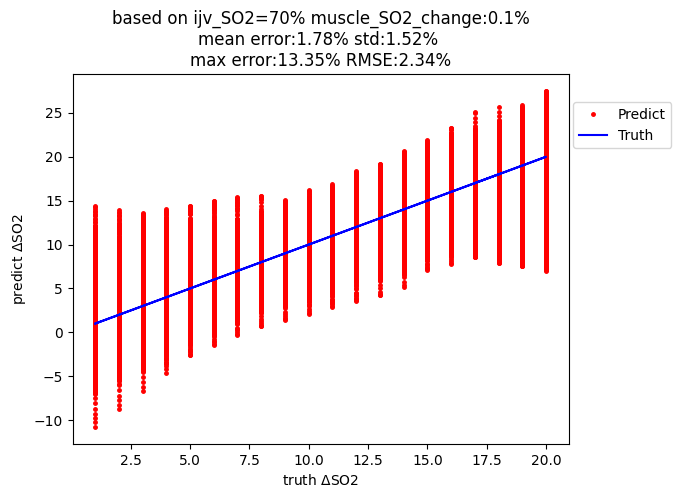

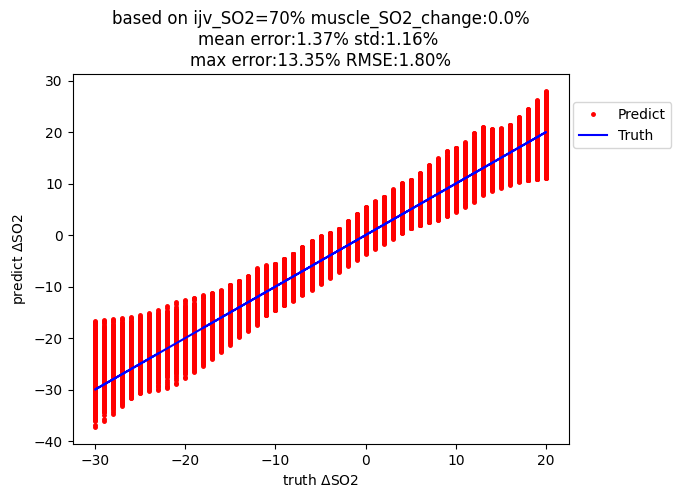

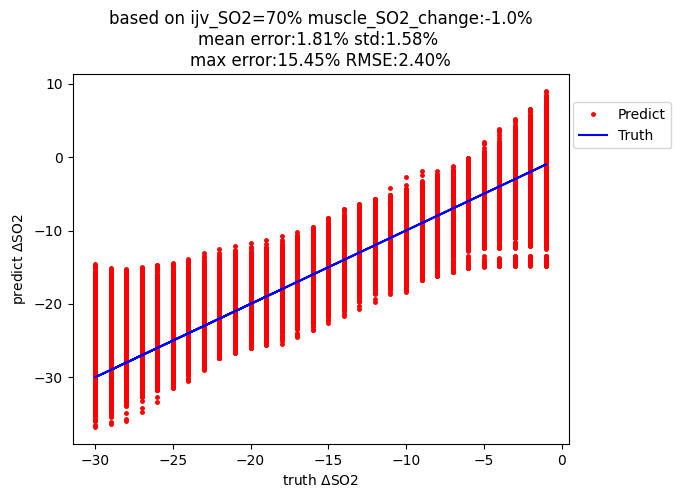

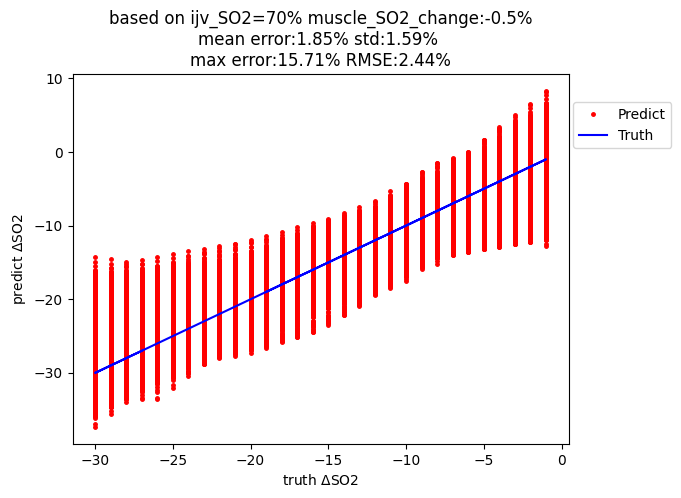

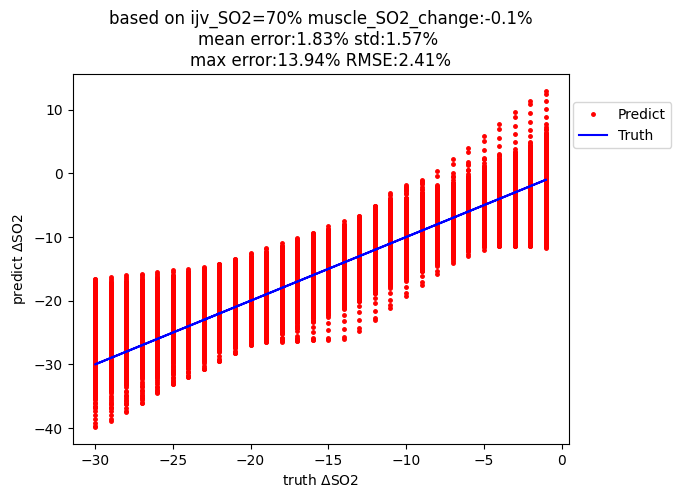

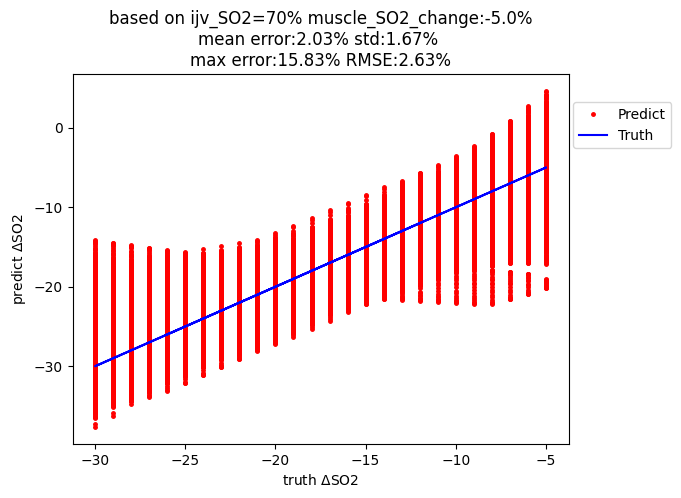

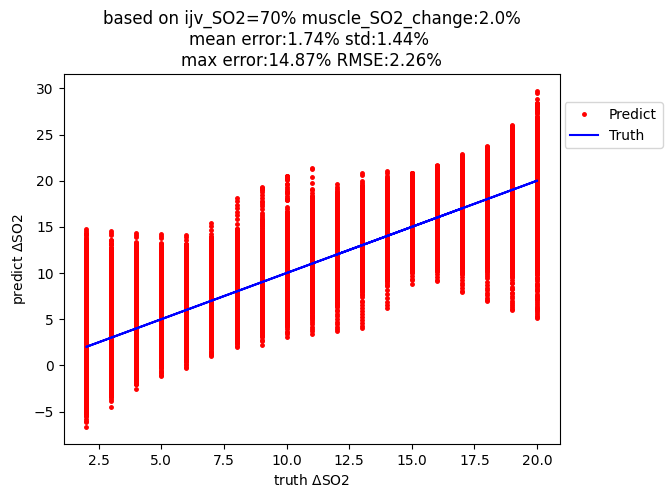

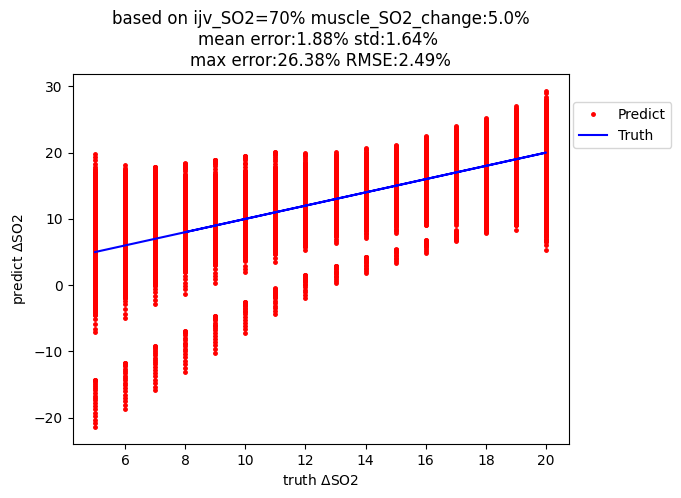

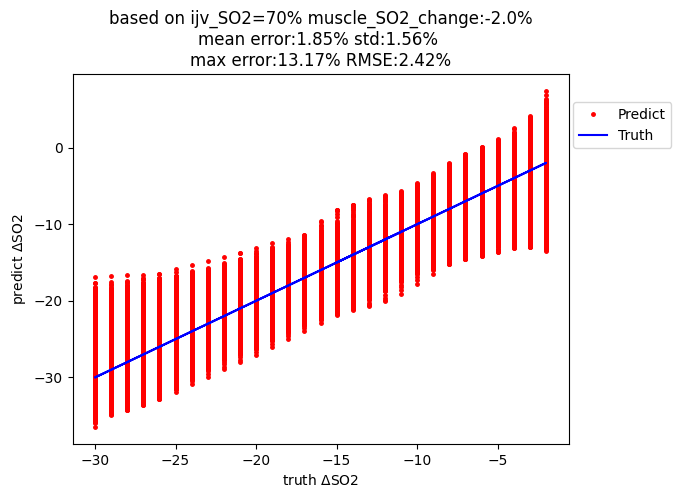

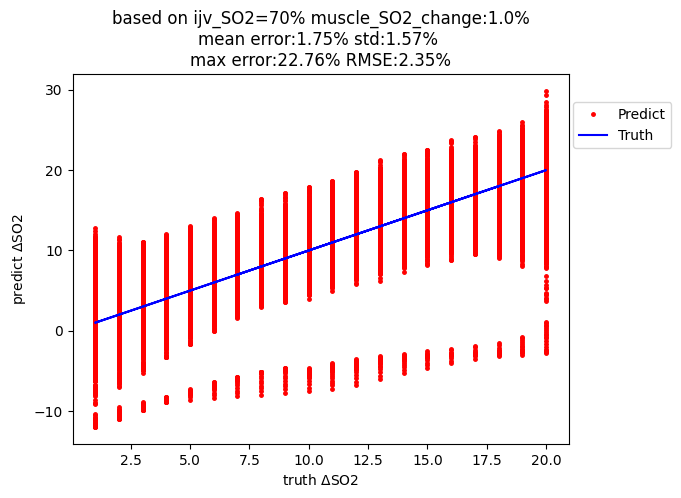

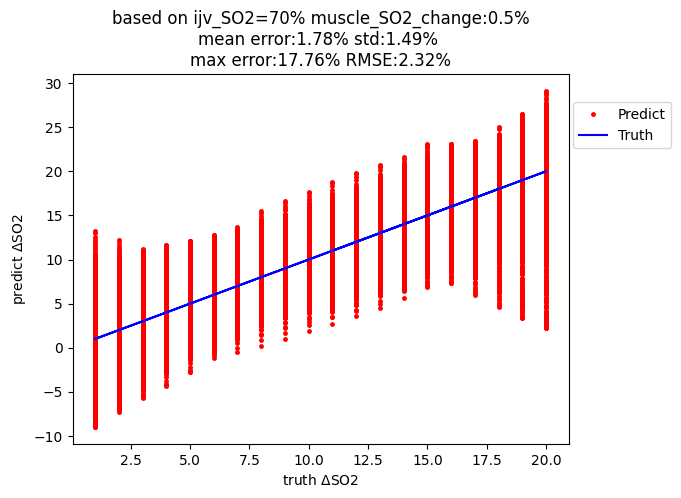

In [6]:
for muscle_mua_change in test_result['muscle_mua_change'].unique():
    temp = test_result[test_result['muscle_mua_change']==muscle_mua_change]
    output = temp['output_ijv_SO2']
    target = temp['target_ijv_SO2']
    error = temp['error_ijv_SO2']
    
    plt.plot(target,output, 'r.', markersize=5, label='Predict')
    plt.plot(target,target,'b', label='Truth')
    RMSE = np.sqrt(np.mean(np.square(error)))
    mean = np.mean(np.abs(error))
    std = np.std(np.abs(error))
    max_error = np.max(np.abs(error))
    plt.title(f"based on ijv_SO2=70% muscle_SO2_change:{muscle_mua_change}%\nmean error:{mean:.2f}% std:{std:.2f}% \nmax error:{max_error:.2f}% RMSE:{RMSE:.2f}%")
    plt.xlabel("truth $\u0394$SO2")
    plt.ylabel("predict $\u0394$SO2")
    plt.legend(loc=(1.01,0.8))
    plt.savefig(os.path.join("pic", result_folder, f"muscle_change_{muscle_mua_change}_RMSE_ijv.png"), dpi=300, format='png', bbox_inches='tight')
    plt.show()